# Presenting latency-coded inputs
In this first tutorial we build an input layer of spiking "projection neurons" for our mushroom body model which converts MNIST digits into latency-coded spikes.

## Install PyGeNN wheel from Google Drive
Download wheel file

In [1]:
if "google.colab" in str(get_ipython()):
    !gdown 128FKTJ1GVF7TgwT9-4o7r4eWqduMYVO4
    !pip install pygenn-5.4.0-cp312-cp312-linux_x86_64.whl
    %env CUDA_PATH=/usr/local/cuda

Downloading...
From: https://drive.google.com/uc?id=1wUeynMCgEOl2oK2LAd4E0s0iT_OiNOfl
To: /content/pygenn-5.1.0-cp311-cp311-linux_x86_64.whl
100% 8.49M/8.49M [00:00<00:00, 57.3MB/s]
Processing ./pygenn-5.1.0-cp311-cp311-linux_x86_64.whl
pygenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
env: CUDA_PATH=/usr/local/cuda


## Install MNIST package

In [2]:
!pip install mnist

## Build tutorial model
Import modules

In [3]:
import mnist
import numpy as np
from copy import copy
from matplotlib import pyplot as plt
from pygenn import create_current_source_model, init_postsynaptic, init_weight_update, GeNNModel

Load training images from downloaded file and normalise so each image's pixels add up to one

In [4]:
mnist.datasets_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
training_images = mnist.train_images()
training_images = np.reshape(training_images, (training_images.shape[0], -1)).astype(np.float32)

training_images /= np.sum(training_images, axis=1)[:, np.newaxis]

## Visualize training data
Reshape first training image from 784 element vector to 28x28 matrix and visualize.

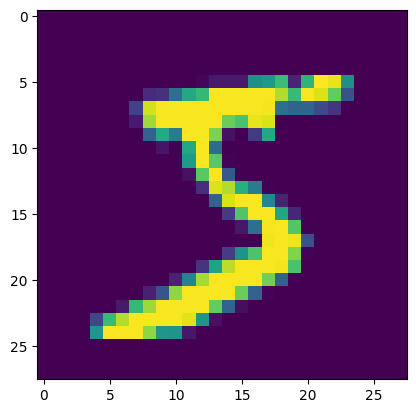

In [5]:
fig, axis = plt.subplots()
axis.imshow(np.reshape(training_images[0], (28, 28)));

## Parameters
Define some model parameters

In [6]:
# Simulation time step
DT = 0.1

# Scaling factor for converting normalised image pixels to input currents (nA)
INPUT_SCALE = 80.0

# Number of Projection Neurons in model (should match image size)
NUM_PN = 784

# How long to present each image to model
PRESENT_TIME_MS = 20.0

Define a standard set of parameters to use for all leaky-integrate and fire neurons

In [7]:
# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

Make a copy of this to customise for our Projection neurons and increase the refractory time way above `PRESENT_TIME_MS` so these neurons will only spike once per input.

In [8]:
# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 100.0

## Custom models
We are going to apply inputs to our model by treating scaled image pixels as neuronal input currents so here we define a simple model to inject the current specified by a state variable. Like all types of custom model in GeNN, the `var_name_types` kwarg is used to specify state variable names and types

In [9]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = create_current_source_model(
    "cs_model",
    vars=[("magnitude", "scalar")],
    injection_code="injectCurrent(magnitude);")

## Model definition
Create a new model called "mnist_mb_first_layer" with floating point precision and set the simulation timestep to our chosen value

In [10]:
# Create model
model = GeNNModel("float", "mnist_mb_first_layer")
model.dt = DT

Add a population of `NUM_PN` Projection Neurons, using the built-in LIF model, the parameters we previously chose and initialising the membrane voltage to the reset voltage.

In [11]:
# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True

Add a current source to inject current into `pn` using our newly-defined custom model with the initial magnitude set to zero.

In [12]:
# Create current sources to deliver input to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})

## Build model
Generate code and load it into PyGeNN allocating a large enough spike recording buffer to cover `PRESENT_TIME_MS` (after converting from ms to timesteps)

In [13]:
# Concert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

## Simulate tutorial model
In order to ensure that the same stimulus causes exactly the same input each time it is presented, we want to reset the model's state after presenting each stimulus. This function resets neuron state variables selected by the keys of a dictionary to the values specifed in the dictionary values and pushes the new values to the GPU.

In [14]:
def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in var_init.items():
        pop.vars[var_name].view[:] = var_val

        # Push the new values to GPU
        pop.vars[var_name].push_to_device()

As an initial test of our model, we loop through 4 stimuli and show the Projection Neurons spikes emitted by the model in response.

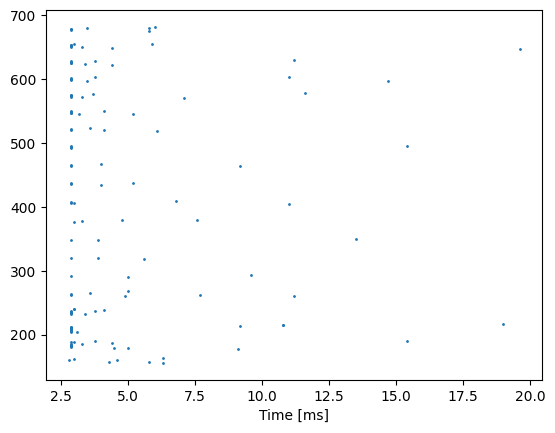

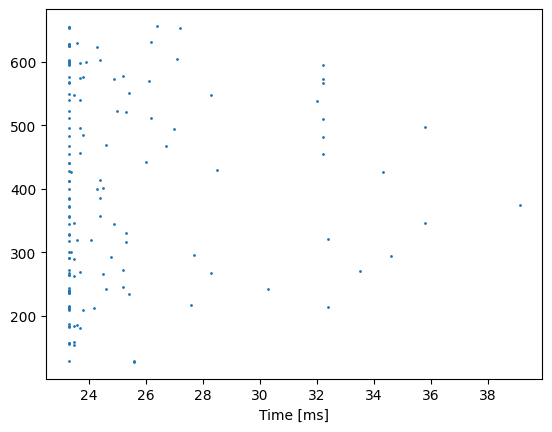

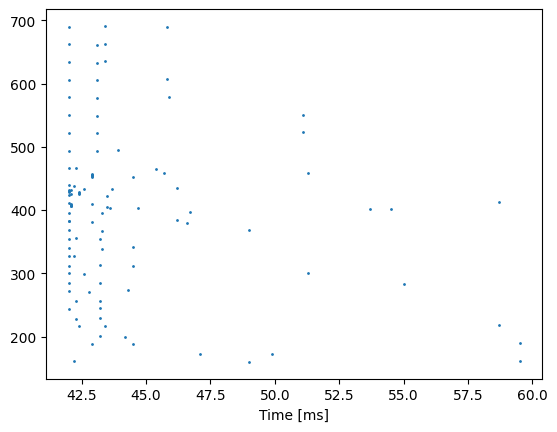

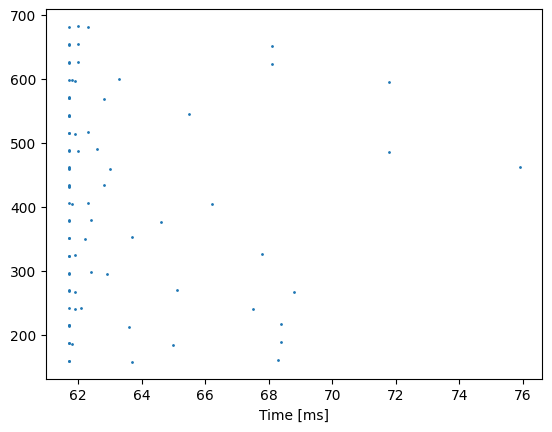

In [15]:
for s in range(4):
    # Set training image
    pn_input.vars["magnitude"].view[:] = training_images[s] * INPUT_SCALE
    pn_input.vars["magnitude"].push_to_device()

    # Simulate timesteps
    for i in range(present_timesteps):
        model.step_time()

    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)

    # Download spikes from GPU
    model.pull_recording_buffers_from_device();

    # Plot PN spikes
    fig, axis = plt.subplots()
    pn_spike_times, pn_spike_ids = pn.spike_recording_data[0]
    axis.scatter(pn_spike_times, pn_spike_ids, s=1)
    axis.set_xlabel("Time [ms]")